In [636]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import xgboost as xgb
import shap
from sklearn.metrics import confusion_matrix, classification_report, auc, roc_curve

# Tabla de Contenidos
1. [Costos Marginales](#Costos-Marginales)
2. [Construccion de Variables](#Construccion-de-variables)
3. [Visualizacion de Datos](#Visualizacion-de-datos)
4. [Base para Modelos](#Base-para-modelos)
5. [Prediccion de desviaciones del costo marginal (modelo 1)](#Prediccion-modelo1)
6. [Prediccion de desviaciones del costo marginal (modelo 2)](#Prediccion-modelo2)
7. [Merge con resultados de clima (modelo 3)](#Prediccion-modelo3)
8. [Reflexion](#Reflexion)

## 1. Costos Marginales<a id='Costos-Marginales'>

### 1.1. Carga de archivos de entrada

In [637]:
# Lista de archivos de entrada
archivo_cm_real = 'costo_marginal_real.csv'
archivo_cm_programado = 'costo_marginal_programado.csv'
base_prediccion = 'base_para_prediccion.csv'
base_para_prediccion = 'base_para_prediccion.csv'
datos_clima = 'datos_clima.csv'

In [638]:
# Se leen archivos de entrada y se almacenan como DataFrame
cm_real = pd.read_csv(archivo_cm_real)
cm_programado = pd.read_csv(archivo_cm_programado)

In [639]:
# Numero de filas por archivo
print("# Filas en archivos:")
print(f'    {archivo_cm_real}:\t\t{cm_real.shape[0]}')
print(f'    {archivo_cm_programado}:\t{cm_programado.shape[0]}')

# Filas en archivos:
    costo_marginal_real.csv:		4309951
    costo_marginal_programado.csv:	1192124


In [640]:
# Datos tabla "costo_real"
cm_real.head(5)

,barra_mnemotecnico,barra_referencia_mnemotecnico,fecha,hora,costo_en_dolares,costo_en_pesos,nombre
0,BA01T005SE075T005,BA02T002SE032T002,2019-04-06,25,62.24,41.47176,BA S/E LORETO 15KV
1,BA01T005SE175T005,BA02T002SE032T002,2019-04-06,25,62.56,41.68498,BA S/E RETIRO 13.2KV
2,BA03R002SE002R002,BA02T002SE032T002,2019-04-06,25,60.04,40.00585,BA S/E ALTAMIRANO 12.5KV BP1
3,BA01R002SE012R002,BA02T002SE032T002,2019-04-06,25,61.65,41.07863,BA S/E CURACAVI 44KV B1
4,BA03R002SE013R002,BA02T002SE032T002,2019-04-06,25,59.55,39.67936,BA S/E EL MANZANO (ENEL DISTRIBUCIÓN) 23KV BP1


In [641]:
# Datos tabla "costo programado"
cm_programado.head(5)

,mnemotecnico_barra,nombre_barra,fecha,hora,costo
0,BA01T002SE002T002,BA S/E ALTO JAHUEL 110KV SECCION 1,2019-01-01,1,49.897334
1,BA01T002SE002T002,BA S/E ALTO JAHUEL 110KV SECCION 1,2019-01-01,2,50.471616
2,BA01T002SE002T002,BA S/E ALTO JAHUEL 110KV SECCION 1,2019-01-01,3,50.077821
3,BA01T002SE002T002,BA S/E ALTO JAHUEL 110KV SECCION 1,2019-01-01,4,49.796216
4,BA01T002SE002T002,BA S/E ALTO JAHUEL 110KV SECCION 1,2019-01-01,5,49.796216


#### 25 horas en un dia?

In [642]:
cm_real[cm_real['hora'] == 25]['fecha'].unique()

array(['2019-04-06'], dtype=object)

Llama la atencion el valor 25 en el campo hora. Al revisar los datos, vemos que corresponde al dia "2019-04-06" en donde hubo cambio de hora en Chile. Para estandarizar los datos, optamos por transformar todas las fechas / horas a UTC. Notar que realizaremos esta operacion en el dataset final (despues de unir las tablas de costo_real y costo_programado)

#### Registros duplicados?

In [643]:
# Revision de registros duplicados
print(f"{cm_real[cm_real.duplicated(subset=['barra_mnemotecnico', 'fecha', 'hora'])].shape[0]} Registros duplicados en: 'archivo_cm_real.csv'")

0 Registros duplicados en: 'archivo_cm_real.csv'


In [644]:
# Revision de registros duplicados
duplicados_cm_prog = cm_programado[cm_programado.duplicated(subset=['mnemotecnico_barra', 'fecha', 'hora'])]
print(f"{duplicados_cm_prog.shape[0]} Registros duplicados en: 'archivo_cm_programado.csv'\n")
print('Codigos de barras con duplicados:')
list(duplicados_cm_prog['mnemotecnico_barra'].unique())

188229 Registros duplicados en: 'archivo_cm_programado.csv'

Codigos de barras con duplicados:


['-', 'BA01T002SE036T002', 'BA02T003SE004T003', 'BA83L131SE134L131']

In [645]:
# Ejemplo de registro duplicado
cm_programado[(cm_programado['mnemotecnico_barra'] == 'BA01T002SE036T002') &
              (cm_programado['fecha'] == '2019-01-01') &
              (cm_programado['hora'] == 1)]

,mnemotecnico_barra,nombre_barra,fecha,hora,costo
1167206,BA01T002SE036T002,BA S/E SAUZAL 110KV SECCION 1,2019-01-01,1,45.465748
1167230,BA01T002SE036T002,BA S/E SAUZAL 110KV SECCION 1,2019-01-01,1,48.695340


Al revisar el ejemplo anterior, vemos que el costo es diferente para dos registros con la misma tupla (barra,fecha,hora). Para manejar este caso se opto por mantener los registros mas recientes (esto asumiendo que el costo programado se ajusto en algun momento en el tiempo y que probablemente son mas cercanos a lo que se requiere)

In [646]:
# Eliminamos los duplicados
cm_programado.drop_duplicates(subset=['mnemotecnico_barra', 'fecha', 'hora'], inplace=True, keep='last')

In [647]:
# Revisamos que efectivamente no existan mas duplicados en la tabla
print(f"{cm_programado[cm_programado.duplicated(subset=['mnemotecnico_barra', 'fecha', 'hora'])].shape[0]} Registros duplicados en: 'archivo_cm_programado.csv'")

0 Registros duplicados en: 'archivo_cm_programado.csv'


### 1.2 Merge de costos reales con costos programados

In [648]:
# Join de tabla "costos reales" y "costos marginales"
costo_marginal = pd.merge(cm_real, cm_programado, left_on=['barra_mnemotecnico', 'fecha', 'hora'], right_on=['mnemotecnico_barra', 'fecha', 'hora'], how='inner')

In [649]:
costo_marginal.shape

(900929, 10)

Al cruzar ambas tablas usando "inner" join, vemos que perdemos registros. Esto se debe a 2 alternativas: o bien, tenemos datos reales que no costo programado o tenemos un costo programado para datos en los que aun no se cuenta con el valor real. Tambien pueden ser ambas opciones. Revisamos que puede estar ocurriendo ...

#### Registros de costos programados sin datos reales

In [650]:
# Exploremos los registros que estan en la tabla "costos marginales programado" y no en la tabla "costos reales"
costo_marginal_right_join = pd.merge(cm_real, cm_programado, left_on=['barra_mnemotecnico', 'fecha', 'hora'], right_on=['mnemotecnico_barra', 'fecha', 'hora'], how='right')
costo_marginal_right_join['fecha_mes_año'] = costo_marginal_right_join['fecha'].str[:-3]

In [651]:
# Obtenemos el listado de las barras / meses para las que tenemos datos programados pero no reales
delta_programado_real = costo_marginal_right_join[costo_marginal_right_join['barra_mnemotecnico'].isna()]
delta_programado_real[['mnemotecnico_barra', 'fecha_mes_año']].drop_duplicates()

,mnemotecnico_barra,fecha_mes_año
312,BA08T002SE003T002,2019-01
336,BA02T003SE002T003,2019-01
672,BA02R002SE007R002,2019-01
768,BA01R002SE050R002,2019-01
816,BA06T002SE008T002,2019-01
...,...,...
987835,-,2019-02
988507,-,2019-03
989251,-,2019-04
989972,-,2019-05


En efecto tenemos 150 diferentes tuplas (barra, mes_año) en las que contamos con un "costo_programado" pero no tenemos su costo real. Ademas, llama la atención ademas el codigo con valor "-".

#### Registros de datos reales sin costo programado

In [652]:
# Exploremos los registros que estan en la tabla "costos marginales programado" y no en la tabla "costos reales"
costo_marginal_left_join = pd.merge(cm_real, cm_programado, left_on=['barra_mnemotecnico', 'fecha', 'hora'], right_on=['mnemotecnico_barra', 'fecha', 'hora'], how='left')
costo_marginal_left_join['fecha_mes_año'] = costo_marginal_left_join['fecha'].str[:-3]

In [653]:
# Obtenemos el listado de las barras / meses para las que tenemos datos programados pero no reales
delta_real_programado = costo_marginal_left_join[costo_marginal_left_join['mnemotecnico_barra'].isna()]
delta_real_programado[['barra_mnemotecnico', 'fecha_mes_año']].drop_duplicates()

,barra_mnemotecnico,fecha_mes_año
0,BA01T005SE075T005,2019-04
1,BA01T005SE175T005,2019-04
2,BA03R002SE002R002,2019-04
3,BA01R002SE012R002,2019-04
4,BA03R002SE013R002,2019-04
...,...,...
134949,BA90T005SE291T005,2019-06
134973,BA95L128SE193L128,2019-06
134987,BA01L004SE001L004,2019-06
134991,BA01G306SE001G306,2019-06


Existen 4717 tuplas (barra, mes_año) en las que existen costos reales sin costos programados.

Teniendo en cuenta estas observaciones trabajaremos solo con los datos que existen en ambas tablas (inner join).

### 1.3 Analisis exploratorio

In [654]:
# Transformamos la fecha y hora a variable "fecha_hora_UTC" para evitar problemas con la hora "25" 
costo_marginal['fecha_hora_UTC'] = pd.to_datetime(costo_marginal['fecha']).dt.tz_localize('America/Santiago').dt.tz_convert('GMT') + \
                                   pd.to_timedelta(costo_marginal['hora'], unit='h')
costo_marginal.rename(columns={'costo_en_dolares' : 'costo_real_dolares',
                               'costo' : 'costo_programado_dolares',}, inplace=True)

In [655]:
# Valores unicos por columna en tabla final
costo_marginal.nunique()

barra_mnemotecnico                  220
barra_referencia_mnemotecnico         1
fecha                               181
hora                                 25
costo_real_dolares                17125
costo_en_pesos                   232447
nombre                              220
mnemotecnico_barra                  220
nombre_barra                        220
costo_programado_dolares         715005
fecha_hora_UTC                     4345
dtype: int64

In [656]:
# Valores unicos por columna en tabla "costos reales"
cm_real.nunique()

barra_mnemotecnico                 1020
barra_referencia_mnemotecnico         1
fecha                               181
hora                                 25
costo_en_dolares                  21969
costo_en_pesos                   499801
nombre                             1020
dtype: int64

Vemos que existen 220 diferentes barras para las que se programa el costo de un total de 1020 barras con datos reales. <b>O sea se programa el costo para un 21.5% de las barras.</b>

In [657]:
# Revisamos un resumen estadistico de los valores de las variables
costo_marginal.describe()

,hora,costo_real_dolares,costo_en_pesos,costo_programado_dolares
count,900929.000000,900929.000000,900929.000000,900929.000000
mean,12.502900,58.562186,39.509009,61.860504
std,6.924005,23.326604,15.588484,23.840405
min,1.000000,0.000000,0.000000,-12.113677
25%,7.000000,48.430000,32.553260,49.964943
50%,13.000000,53.330000,35.967440,55.029404
75%,19.000000,60.890000,41.252230,64.107227
max,25.000000,791.140000,523.418220,610.600000


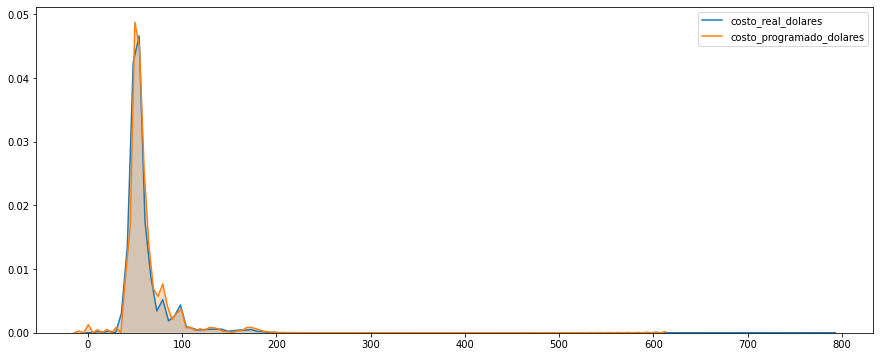

In [658]:
# Revisamos la distribucion de la variable "costo en dolares" costo
fig, ax = plt.subplots(1,1, figsize=(15,6))

sns.kdeplot(data=costo_marginal['costo_real_dolares'], shade=True, ax=ax);
sns.kdeplot(data=costo_marginal['costo_programado_dolares'], shade=True, ax=ax);

De los graficos anteriores, vemos que tanto el costo real como el costo programado tienen una distribucion con una "cola" larga hacia la derecha. Vale la pena revisar mas adelante si estos valores efectivamente corresponden a "outliers" o si bien es parte de lo que se quiere predecir. Ademas llama la atencion que el costo programado tenga un par de valores negativos.


## 2. Construccion de variables<a id='Construccion-de-variables'>

In [659]:
# Construimos las variables de desviacion, desviacion porcentual y desviacion categorica
umbral_pct = 0.15

costo_marginal['desviacion'] = costo_marginal['costo_real_dolares'] - costo_marginal['costo_programado_dolares']
costo_marginal['desviacion_pct'] = (costo_marginal['costo_programado_dolares'] - costo_marginal['costo_real_dolares'])/costo_marginal['costo_programado_dolares']
costo_marginal['desviacion_cat'] =  costo_marginal.apply(lambda x: 1 if abs(x['desviacion_pct']) > umbral_pct else 0, axis=1)

In [660]:
# Revisamos los valores estadisticos de las variables creadas
costo_marginal[['desviacion', 'desviacion_pct', 'desviacion_cat']].describe()

,desviacion,desviacion_pct,desviacion_cat
count,900929.000000,9.008940e+05,900929.000000
mean,-3.298319,-inf,0.258112
std,23.824479,NaN,0.437596
min,-564.190000,-inf,0.000000
25%,-4.887620,-1.582842e-02,0.000000
50%,-0.802219,1.489440e-02,0.000000
75%,0.878430,9.038762e-02,1.000000
max,686.702248,1.786050e+02,1.000000


De la tabla anterior, vemos que existen valores de "desviacion_pct" con valores NaN o inf. Estos se deben probablemente a valores con "costo_programado_dolares" en 0. Revisemos los datos mas a fondo ...

### Desviacion_pct, valores inf o NaN

In [661]:
# Casos en los que "desviacion_pct" tiene valores Infinitos
costo_marginal[np.isinf(costo_marginal['desviacion_pct'])].head()

,barra_mnemotecnico,barra_referencia_mnemotecnico,fecha,hora,costo_real_dolares,costo_en_pesos,nombre,mnemotecnico_barra,nombre_barra,costo_programado_dolares,fecha_hora_UTC,desviacion,desviacion_pct,desviacion_cat
12351,BA01G006SE001G104,BA02T002SE032T002,2019-03-20,1,37.05,24.72013,BA S/E TALINAY 220KV,BA01G006SE001G104,BA S/E TALINAY 220KV,0.0,2019-03-20 04:00:00+00:00,37.05,-inf,1
49993,BA01G006SE001G104,BA02T002SE032T002,2019-03-20,2,45.80,30.55822,BA S/E TALINAY 220KV,BA01G006SE001G104,BA S/E TALINAY 220KV,0.0,2019-03-20 05:00:00+00:00,45.80,-inf,1
87531,BA01G006SE001G104,BA02T002SE032T002,2019-03-20,3,44.28,29.54406,BA S/E TALINAY 220KV,BA01G006SE001G104,BA S/E TALINAY 220KV,0.0,2019-03-20 06:00:00+00:00,44.28,-inf,1
124991,BA01G006SE001G104,BA02T002SE032T002,2019-03-20,4,43.24,28.85016,BA S/E TALINAY 220KV,BA01G006SE001G104,BA S/E TALINAY 220KV,0.0,2019-03-20 07:00:00+00:00,43.24,-inf,1
162604,BA01G006SE001G104,BA02T002SE032T002,2019-03-20,5,42.51,28.36310,BA S/E TALINAY 220KV,BA01G006SE001G104,BA S/E TALINAY 220KV,0.0,2019-03-20 08:00:00+00:00,42.51,-inf,1


In [662]:
# Casos en los que "desviacion_pct" tiene valores NaN
costo_marginal[np.isnan(costo_marginal['desviacion_pct'])].head()

,barra_mnemotecnico,barra_referencia_mnemotecnico,fecha,hora,costo_real_dolares,costo_en_pesos,nombre,mnemotecnico_barra,nombre_barra,costo_programado_dolares,fecha_hora_UTC,desviacion,desviacion_pct,desviacion_cat
447400,BA56G216SE023G216,BA02T002SE032T002,2019-01-09,12,0.0,0.0,BA S/E ARICA 66KV-BP,BA56G216SE023G216,BA S/E ARICA 66KV-BP,0.0,2019-01-09 15:00:00+00:00,0.0,NaN,0
447500,BA89G216SE030G216,BA02T002SE032T002,2019-01-09,12,0.0,0.0,BA S/E CENTRAL CHAPIQUIÑA 66KV-BP,BA89G216SE030G216,BA S/E CENTRAL CHAPIQUIÑA 66KV-BP,0.0,2019-01-09 15:00:00+00:00,0.0,NaN,0
484947,BA89G216SE030G216,BA02T002SE032T002,2019-01-09,13,0.0,0.0,BA S/E CENTRAL CHAPIQUIÑA 66KV-BP,BA89G216SE030G216,BA S/E CENTRAL CHAPIQUIÑA 66KV-BP,0.0,2019-01-09 16:00:00+00:00,0.0,NaN,0
485008,BA56G216SE023G216,BA02T002SE032T002,2019-01-09,13,0.0,0.0,BA S/E ARICA 66KV-BP,BA56G216SE023G216,BA S/E ARICA 66KV-BP,0.0,2019-01-09 16:00:00+00:00,0.0,NaN,0
522473,BA56G216SE023G216,BA02T002SE032T002,2019-01-09,14,0.0,0.0,BA S/E ARICA 66KV-BP,BA56G216SE023G216,BA S/E ARICA 66KV-BP,0.0,2019-01-09 17:00:00+00:00,0.0,NaN,0


Podemos concluir que efectivamente los problemas ocurren cuando el valor "costo_programado_dolares" es 0 o bien cuando ambos costos_programados son 0. A continuacion filtraremos estos datos para evitar problemas en futuros analisis pero antes, revisaremos si existe alguna barra con todos sus costos_reales en 0 para responder una de las futuras preguntas del desafio

In [663]:
# Agrupamos los datos por barra y costo y buscamos algun valor que tenga su maximo en 0
datos_barra_costos_agrupados = costo_marginal.groupby(by=['barra_mnemotecnico'], as_index=False)['costo_real_dolares'].max().sort_values(by='costo_real_dolares', ascending=True)
datos_barra_costos_agrupados[datos_barra_costos_agrupados['costo_real_dolares'] == 0]

,barra_mnemotecnico,costo_real_dolares
11,BA01G049SE001G049,0.0


Vemos que la barra "BA01G049SE001G049" es la unica con todos sus costos reales en dolares en 0. Filtramos este y todos los valores con "costo_real_dolares" en 0 a continuacion

In [664]:
# Casos en los que "desviacion_pct" tiene valores NaN
registros_inf_NaN = costo_marginal[np.isnan(costo_marginal['desviacion_pct']) | 
                                   np.isinf(costo_marginal['desviacion_pct'])].index
costo_marginal.drop(registros_inf_NaN, inplace=True)

In [665]:
# Revisamos los valores estadisticos sin los registros con problemas
costo_marginal[['desviacion', 'desviacion_pct', 'desviacion_cat']].describe()

,desviacion,desviacion_pct,desviacion_cat
count,900694.000000,900694.000000,900694.000000
mean,-3.310021,-0.749003,0.257958
std,23.814668,25.873889,0.437511
min,-564.190000,-1675.501125,0.000000
25%,-4.889696,-0.015796,0.000000
50%,-0.804107,0.014918,0.000000
75%,0.876772,0.090411,1.000000
max,686.702248,178.604985,1.000000


Ahora los valores hacen sentido, revisemos como se ven graficamente a continuacion

## 3. Visualizacion de datos<a id='Visualizacion-de-datos'>

In [666]:
# Generamos una funcion para graficar un periodo de tiempo. Incluimos una variable "freq" para graficar para cierto periodo de tiempo (D-dia, W-week, M-mes, etc)
def time_plot_costo_barra(codigo_barra, fecha_inicial, fecha_final, figsize=(15,6), freq=None):
    plot_data = costo_marginal[(costo_marginal['barra_mnemotecnico'] == codigo_barra) &
                               (costo_marginal['fecha'] > fecha_inicial) &
                               (costo_marginal['fecha'] < fecha_final)]
    plot_data.set_index('fecha_hora_UTC', inplace=True)
    
    if freq:
        plot_data = plot_data.resample(freq).median()
    
    fig, ax = plt.subplots(figsize=figsize)
    plot_data.plot(y='costo_real_dolares', label='cmg_real', ax=ax, alpha=0.8)
    plot_data.plot(y='costo_programado_dolares', label='cmg_prog', ax=ax, alpha=0.8)
    
    plt.ylabel('Costo [USD/MWh]')
    plt.title('Costo v/s Fecha')
    plt.xticks(rotation=45)

#### 3.1. Plot de datos por hora

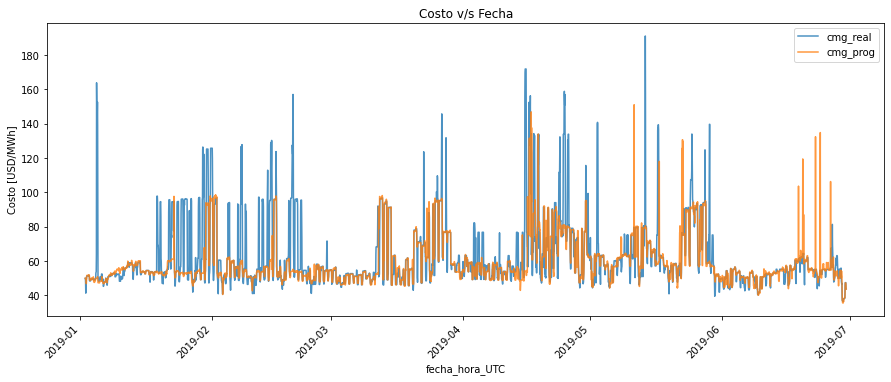

In [667]:
# Grafico por hora
time_plot_costo_barra('BA01G021SE018G021', '2019-01-01', '2019-06-30')

#### 3.2. Plot de datos por semana y por dia

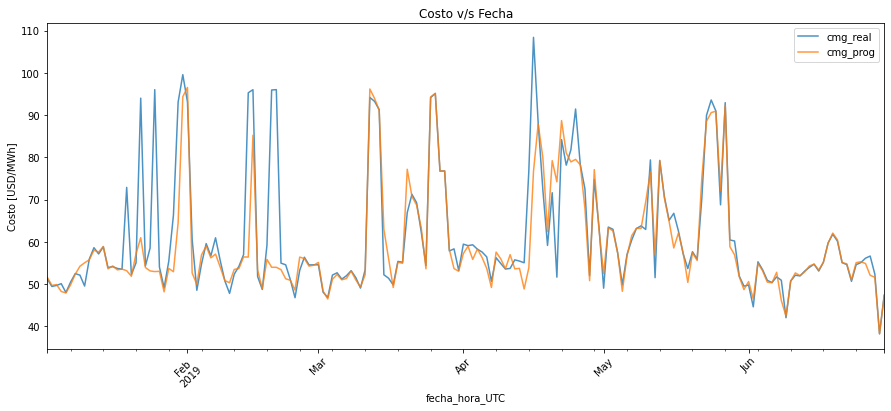

In [668]:
# Grafico por dia
time_plot_costo_barra('BA01G021SE018G021', '2019-01-01', '2019-06-30', freq='D');

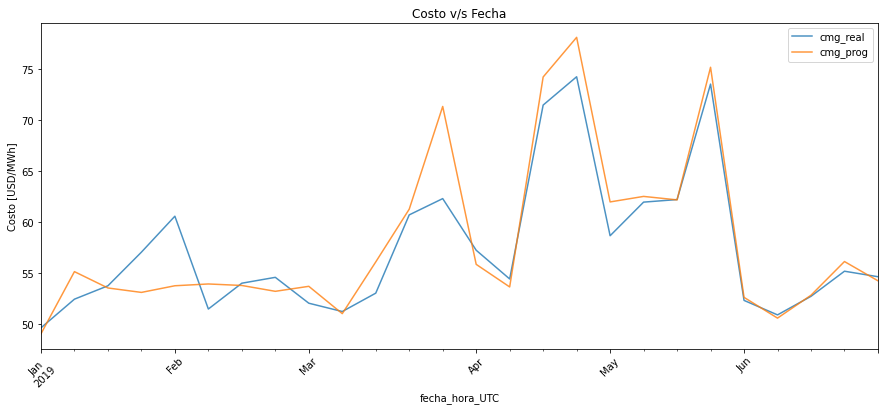

In [669]:
# Grafico por semana
time_plot_costo_barra('BA01G021SE018G021', '2019-01-01', '2019-06-30', freq='W');

Viendo los graficos anterior, se aprecia que existe una desviacion mas marcada en el periodo comprendiendo entre mediados de Enero y fines de Febrero. Efecto vacaciones?

### 4. Base para modelos<a id='Base-para-modelos'>

#### 4.1. Analisis exploratorio

In [670]:
# Se lee archivo base para prediccion
base_modelo = pd.read_csv(base_para_prediccion)

In [671]:
base_modelo.head(4)

,nemotecnico_se,fecha,hora,gen_eolica_total_mwh,gen_geotermica_total_mwh,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,cmg_desv,cmg_desv_pct,n_barras,demanda_mwh,cap_inst_mw
0,SE031G216,2019-01-04 00:00:00 UTC,1,NaN,NaN,NaN,NaN,0.0,56.2,55.627852,0.57,1.02,2,1210767,13.20785
1,SE031G216,2019-01-04 00:00:00 UTC,2,NaN,NaN,NaN,NaN,0.0,56.2,55.376645,0.82,1.48,2,113232,13.20785
2,SE031G216,2019-01-04 00:00:00 UTC,3,NaN,NaN,NaN,NaN,0.0,56.2,59.531891,-3.33,-5.59,2,1089415,13.20785
3,SE031G216,2019-01-04 00:00:00 UTC,4,NaN,NaN,NaN,NaN,0.0,56.2,174.378923,-118.18,-67.77,2,1096867,13.20785


In [672]:
# Descripcion archivo
print(f"# Filas: \t\t{base_modelo.shape[0]}")
print(f"# Columnas: \t\t{base_modelo.shape[1]}")

# Filas: 		112779
# Columnas: 		15


In [673]:
base_modelo.describe()

,hora,gen_eolica_total_mwh,gen_geotermica_total_mwh,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,cmg_desv,cmg_desv_pct,n_barras,demanda_mwh,cap_inst_mw
count,112779.000000,0.0,0.0,34184.000000,41818.000000,61863.000000,112779.000000,112779.000000,112779.000000,112779.00,112779.000000,1.127790e+05,112779.000000
mean,12.502993,NaN,NaN,38.120053,3.764987,40.583146,61.170058,62.215400,-1.045338,inf,2.331844,6.357056e+07,128.719565
std,6.924090,NaN,NaN,69.838109,12.904388,101.083396,25.414147,25.307759,24.711575,NaN,1.304096,3.948683e+08,167.948649
min,1.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,-1.713131,-562.470000,-3403.97,1.000000,-9.821095e+09,2.989800
25%,7.000000,NaN,NaN,0.849787,0.000000,0.000000,49.130000,49.906745,-3.790000,-7.07,1.000000,7.464800e+05,18.420000
50%,13.000000,NaN,NaN,9.600000,0.000000,0.000000,54.610000,55.420601,-0.310000,-0.58,2.000000,4.507282e+06,51.850000
75%,19.000000,NaN,NaN,40.000000,1.571022,15.960000,63.500000,64.701951,1.670000,2.92,3.000000,1.332345e+07,184.685500
max,25.000000,NaN,NaN,472.000000,86.050000,570.600800,240.360000,610.600000,175.020000,inf,6.000000,1.004240e+10,597.782800


In [674]:
# Tipos de dato
base_modelo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112779 entries, 0 to 112778
Data columns (total 15 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   nemotecnico_se            112779 non-null  object 
 1   fecha                     112779 non-null  object 
 2   hora                      112779 non-null  int64  
 3   gen_eolica_total_mwh      0 non-null       float64
 4   gen_geotermica_total_mwh  0 non-null       float64
 5   gen_hidraulica_total_mwh  34184 non-null   float64
 6   gen_solar_total_mwh       41818 non-null   float64
 7   gen_termica_total_mwh     61863 non-null   float64
 8   cmg_real                  112779 non-null  float64
 9   cmg_prog                  112779 non-null  float64
 10  cmg_desv                  112779 non-null  float64
 11  cmg_desv_pct              112779 non-null  float64
 12  n_barras                  112779 non-null  int64  
 13  demanda_mwh               112779 non-null  i

In [675]:
base_modelo.nunique()

nemotecnico_se                  29
fecha                          181
hora                            25
gen_eolica_total_mwh             0
gen_geotermica_total_mwh         0
gen_hidraulica_total_mwh     10261
gen_solar_total_mwh          16212
gen_termica_total_mwh         4371
cmg_real                     13848
cmg_prog                     99157
cmg_desv                     18361
cmg_desv_pct                 21345
n_barras                         6
demanda_mwh                 102625
cap_inst_mw                     29
dtype: int64

<u>Algunas observaciones:</u>
 - variable 'gen_eolica_total_mwh' y 'gen_geotermica_total_mwh' son siempre nulas, por lo que podemos eliminarlas del dataset
 - Costo marginal porcentual tiene valores Inf. Probablemente debido a valores de costos reales programados en 0

#### Preproceso de datos

In [676]:
# Eliminamos las columnas con datos 100% vacios
base_modelo.drop(columns=['gen_eolica_total_mwh', 'gen_geotermica_total_mwh'], inplace=True)

In [677]:
# Eliminamos las filas donde el valor de "cmg_desv_pct" es infinito
base_modelo[np.isinf(base_modelo['cmg_desv_pct'])]

,nemotecnico_se,fecha,hora,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,cmg_desv,cmg_desv_pct,n_barras,demanda_mwh,cap_inst_mw
29512,SE005T003,2019-05-19 00:00:00 UTC,10,6.22733,NaN,NaN,54.51,0.0,54.51,inf,2,2970411,9.952


In [678]:
base_modelo.drop(base_modelo[np.isinf(base_modelo['cmg_desv_pct'])].index, inplace=True)

#### 4.2. Creacion de nuevas variables en base a variable de tiempo

In [679]:
fecha_hora = pd.to_datetime(base_modelo['fecha'])

base_modelo['año'] = fecha_hora.dt.year
base_modelo['mes'] = fecha_hora.dt.month
base_modelo['semana'] = fecha_hora.dt.weekofyear
base_modelo['dia'] = fecha_hora.dt.day
base_modelo['dia_semana'] = fecha_hora.dt.dayofweek

base_modelo['fin_de_semana'] = 0
base_modelo.loc[base_modelo['dia_semana'].isin([5,6]), 'fin_de_semana'] = 1

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


#### 4.3. Funcion para graficar subestacion y variable

In [680]:
# Funcion para graficar una variable de una subestacion para un periodo de fechas
def time_plot_subestacion_variable(codigo_se, variable, fechas_a_graficar):
    
    fig, ax = plt.subplots(figsize=(15,8))
    plot_data = base_modelo.loc[(base_modelo['nemotecnico_se'] == codigo_se) & 
                                (base_modelo['fecha'].str[:10].isin(fechas_a_graficar)), ['fecha', 'hora', variable]].copy()
    sns.lineplot(x='hora', y=variable, hue='fecha', data=plot_data);
    plt.title(f'{variable} por hora (sub-estacion: {codigo_se})')

##### 4.3.1. Curva de generacion solar 

###### subestacion: SE005T002 ; fechas: 10, 11, 12, 13 y 14 de enero de 2019

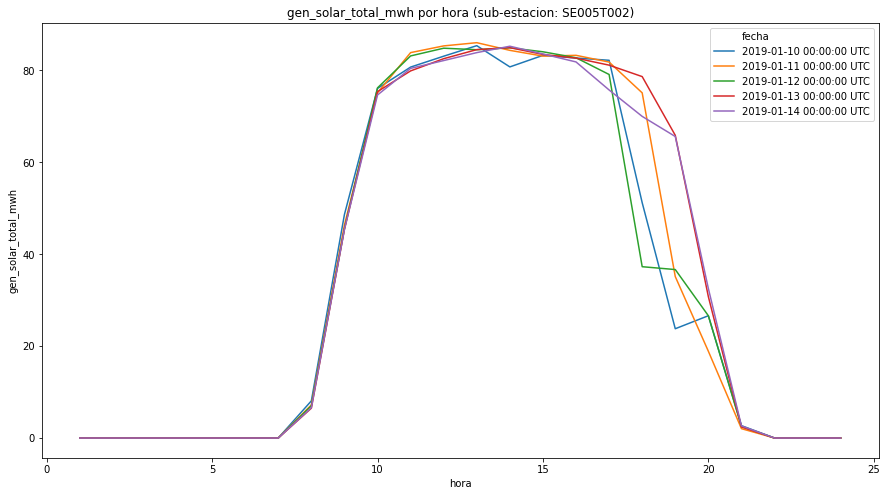

In [681]:
time_plot_subestacion_variable('SE005T002', 'gen_solar_total_mwh', ['2019-01-10', '2019-01-11' ,'2019-01-12', '2019-01-13', '2019-01-14'])

###### subestacion: SE127T005 ; fechas: 10, 11, 12, 13 y 14 de enero de 2019

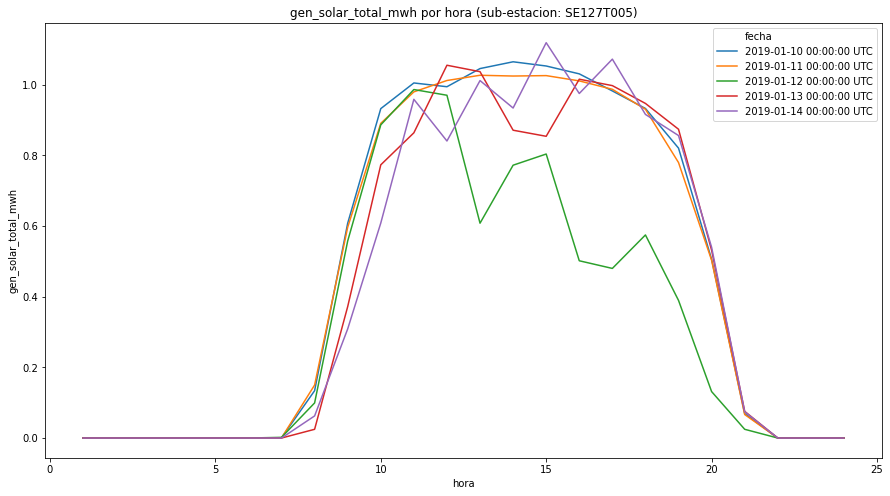

In [682]:
time_plot_subestacion_variable('SE127T005', 'gen_solar_total_mwh', ['2019-01-10', '2019-01-11' ,'2019-01-12', '2019-01-13', '2019-01-14'])

En base a los graficos anteriores, es claro que la generacion de energia solar ocurre principalmente entre las 8 AM y 22 PM. Tambien da la impresion que la generacion de energia solar para la segunda subestacion tiene un poco mas ruido o fue menos constante. Efectos del clima? Tal vez estuvo con lluvia o nublado o derechamente podria ser que la subestacion se encuentra en un lugar donde el sol llega de manera menos directa ...

##### 4.3.2. Curva de generacion termica

###### subestacion: SE020G213 ; fechas: 14, 15, 16, 17 mayo de 2019

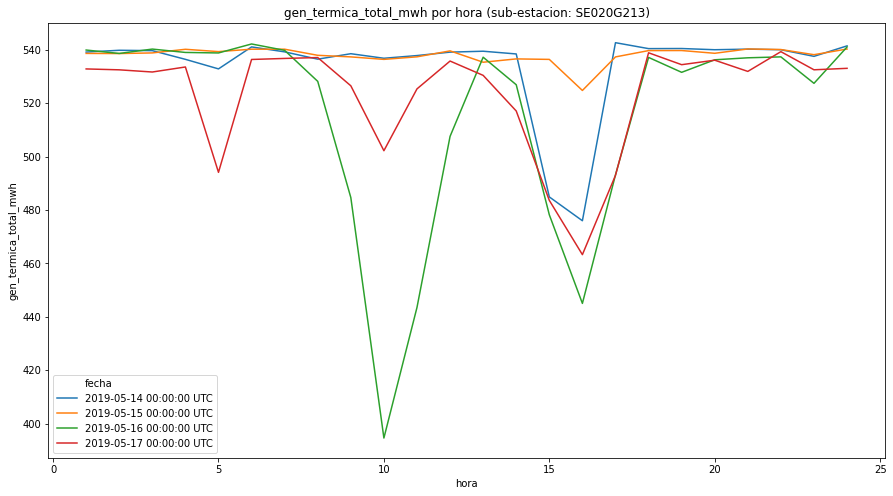

In [683]:
time_plot_subestacion_variable('SE020G213', 'gen_termica_total_mwh', ['2019-05-14', '2019-05-15' ,'2019-05-16', '2019-05-17'])

###### subestacion: SE106G216 ; fechas: 14, 15, 16, 17 mayo de 2019

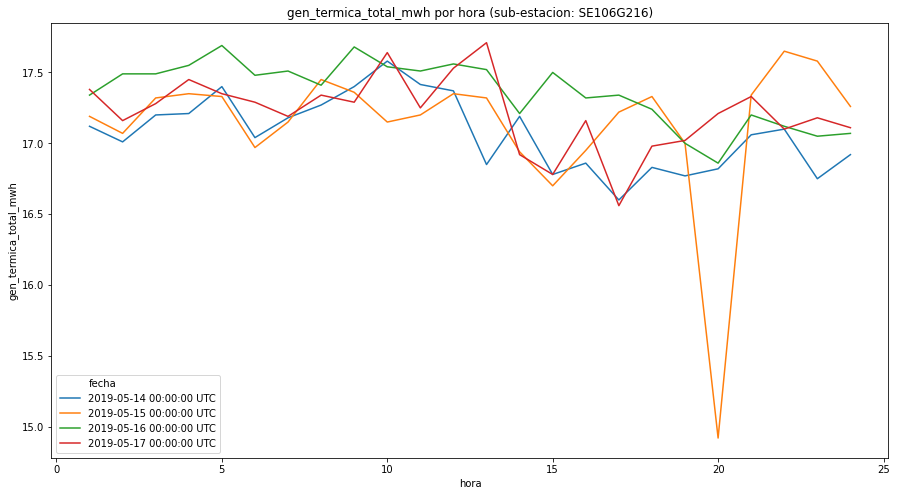

In [684]:
time_plot_subestacion_variable('SE106G216', 'gen_termica_total_mwh', ['2019-05-14', '2019-05-15' ,'2019-05-16', '2019-05-17'])

En base a los graficos anteriores, es claro que la energia termica es mas constante que la energia solar respecto al tiempo. Ahora bien, la energia promedio producida en la subestacion "SE020G213" en las mismas fechas fue de 520 [MWh] versus la segunda que produjo 17.2 [MWh]. La diferencia es considerable por lo que habria que revisar si esto de debe a un tema de ubicacion o derechamente algun funcionamiento errado

### 5. Prediccion de desviaciones del costo marginal: modelo 1<a id='Prediccion-modelo1'>

In [685]:
# Creacion variable target. Adaptamos la variable usando de un periodo para predecir la proxima hora
umbral_pct = 15

base_modelo['cmg_desv_ind'] = base_modelo.apply(lambda x: 0 if abs(x['cmg_desv_pct']) <= umbral_pct else 1, axis = 1)
base_modelo.sort_values(by=['nemotecnico_se', 'fecha', 'hora'], inplace=True)
base_modelo['target'] = base_modelo.groupby(by=['nemotecnico_se'])['cmg_desv_ind'].shift(-1)
base_modelo.dropna(subset=["target"], inplace=True)

In [686]:
# Creacion de features
base_modelo['en_total_mwh'] = base_modelo['gen_hidraulica_total_mwh'].fillna(0) + \
                              base_modelo['gen_solar_total_mwh'].fillna(0) + \
                              base_modelo['gen_termica_total_mwh'].fillna(0)

# Añadimos variables correspondientes a la variable "target" desfasada en el tiempo
periodos_lag = 24

for i in range(1, periodos_lag + 1):
    base_modelo[f"cmg_desv_ind_{i}hrs"] = base_modelo.groupby(by=['nemotecnico_se'])['cmg_desv_ind'].shift(i)


base_modelo.dropna(subset=[f"cmg_desv_ind_{i}hrs" for i in range(1, periodos_lag + 1)], inplace=True)

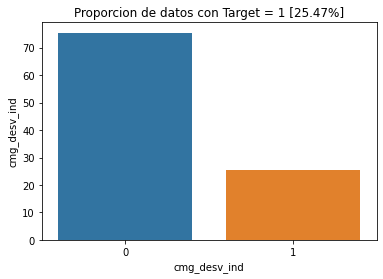

In [687]:
# Revisamos que tan desbalanceada esta nuestra variable a predecir
ax = sns.barplot(x="cmg_desv_ind", y="cmg_desv_ind", data=base_modelo, estimator=lambda x: len(x) / len(y) * 100).set_title(f'Proporcion de datos con Target = 1 [{100*sum(base_modelo["cmg_desv_ind"])/len(y):.2f}%]')

Vemos que el dataset esta desbalanceado 25% vs 75%. Esto es esperable a menos que nuestros datos programados esten muy desviados respecto al real

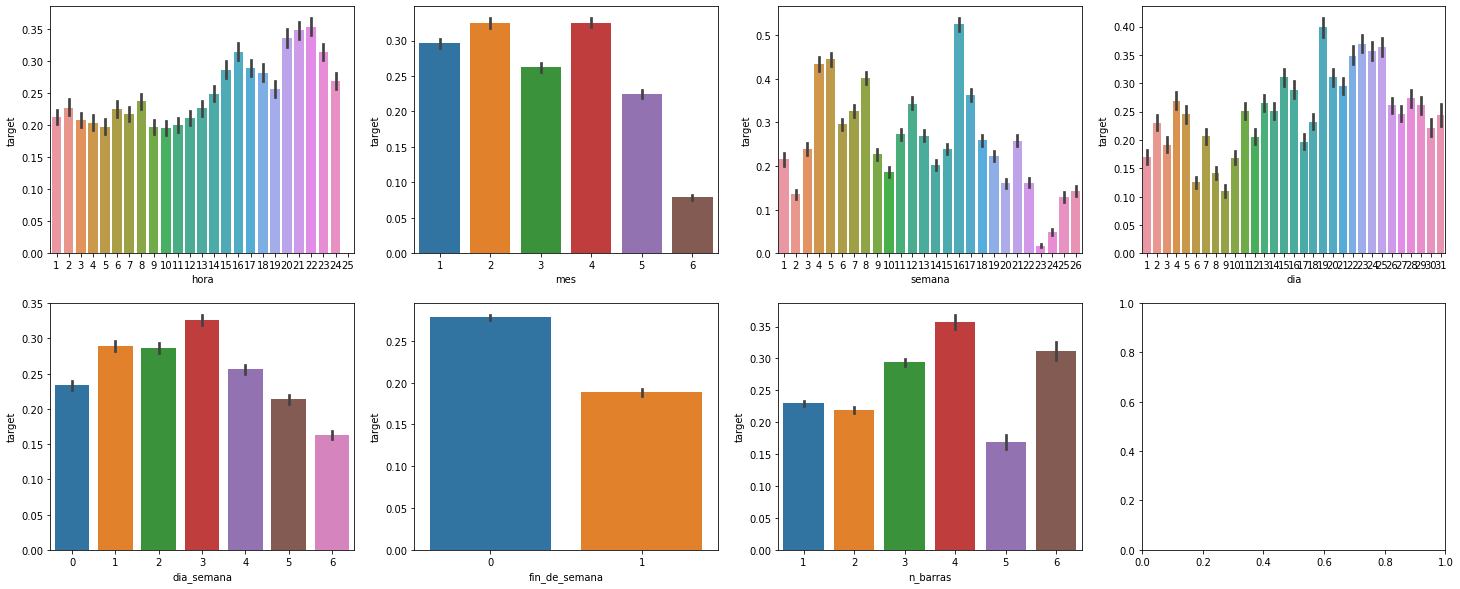

In [688]:
# Revisamos la distribucion de la variable "target" versus otras variables categoricas
variables_categoricas = ['hora', 'mes', 'semana', 'dia', 'dia_semana', 'fin_de_semana', 'n_barras']
fig, axes = plt.subplots(2, 4, figsize=(25, 10))
for col, ax in zip(variables_categoricas, axes.flatten()):
    g = sns.barplot(x=col, y="target", data=base_modelo, ax=ax) 

<u>Algunas impresiones:</u>
 - Al parecer, es mas probable que los desvios ocurran entre 16:00 y 22:00 hrs (tarde / noche)
 - Hay pocos desvios de valores reales v/s programados para el mes de Junio
 - Al parecer, es menos probable que ocurra un desvio los fines de semana
 - Es mas probable que ocurra un desvio cuando hay mas barras a excepcion del caso de 5 barras. Me parece relevante revisar que pasa en ese caso especifico. Outlier?
 

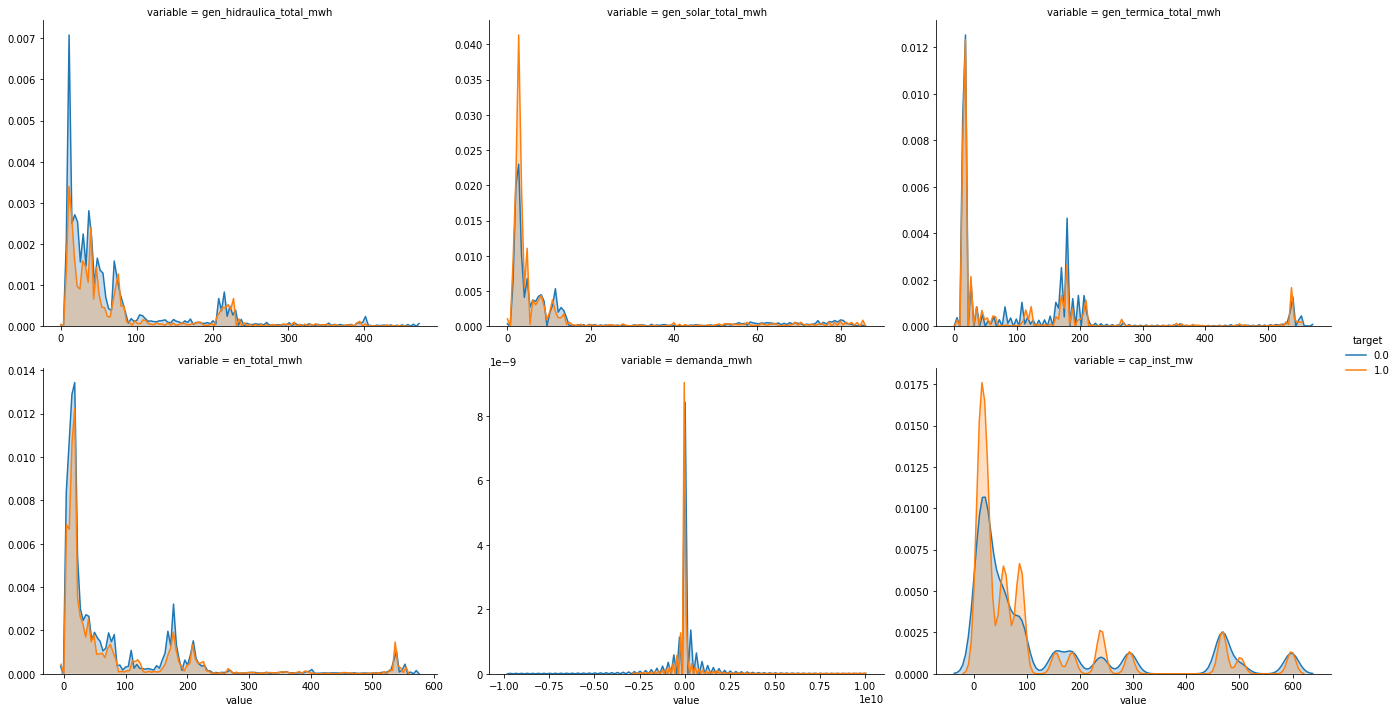

In [689]:
# Revisamos la distribucion de la variable "target" versus otras variables categoricas
variables_continuas = ['gen_hidraulica_total_mwh','gen_solar_total_mwh',
                       'gen_termica_total_mwh', 'en_total_mwh',
                       'demanda_mwh', 'cap_inst_mw']
base_modelo_transformada = pd.melt(base_modelo, 'target', variables_continuas).fillna(0)

g = sns.FacetGrid(base_modelo_transformada, col="variable", hue="target", col_wrap=3, sharex=False, sharey=False,height=5,aspect=1.25)
g.map(sns.kdeplot, "value", shade=True)
g.add_legend();

No se ve una gran diferencia cuando existe o no una desviacion en las variables continuas. No creo que ayuden mucho para nuestro modelo.

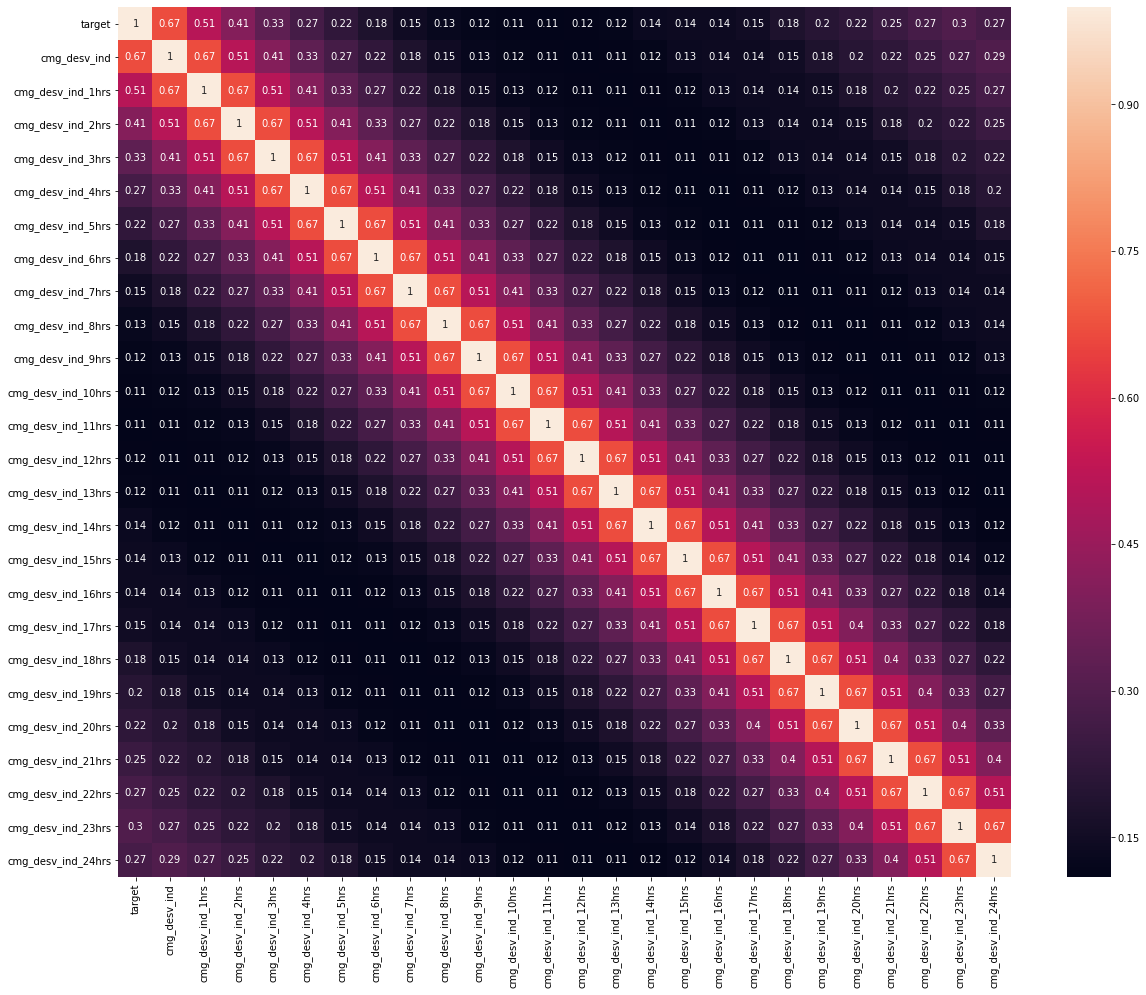

In [690]:
variables_lag = ["cmg_desv_ind"] + [f"cmg_desv_ind_{i}hrs" for i in range(1, periodos_lag + 1)] 
fig, ax = plt.subplots(1,1, figsize=(20,16))
sns.heatmap(base_modelo[['target'] + variables_lag].corr(), annot=True);

De los graficos anteriores vemos que el flag de desvio de costo marginal (cmg_desv_ind) junto con el lag de esta misma variable para las horas 1, 2, 3 y 4 parecieran ayudar a predecir nuestra variable "target"

#### 5.1. Construccion del modelo usando XGBoost

In [691]:
# Creamos el modelo usando una "semilla" fija para obtener resultados deterministicos. Incluimos tambien un argumento para considerar las clases desbalanceadas
seed = 1234
model = xgb.XGBClassifier(n_estimators=500, learning_rate=0.01, scale_pos_weight=3, seed=seed)

In [692]:
# Funcion para hacer una division de train/test respetando la estructura de series de tiempo
def timeseries_train_test_split(X, y, test_size):
    """
        Funcion para hacer un "split" de train-test manteniendo la estructura de time-series
    """
    
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [693]:
# Transformamos la base modelo en train/test manteniendo la estructura de la serie de tiempo
X = base_modelo.drop(columns='target')
X = X[variables_continuas + variables_categoricas + variables_lag]
y = base_modelo['target']

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.2)

In [694]:
# Entrenamos el modelo usando XGBoost
result = model.fit(X_train, y_train)

In [695]:
# Revisamos los resultados v/s nuestro test set
y_pred = result.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.88      0.90     16235
         1.0       0.71      0.78      0.75      6176

    accuracy                           0.85     22411
   macro avg       0.81      0.83      0.82     22411
weighted avg       0.86      0.85      0.86     22411



In [696]:
# Estimamos el indice AUC (Area under the curve), como metrica para evaluar el modelo
fpr, tpr, _ = roc_curve(y_test, y_pred)
print(f'AUC score: {auc(fpr, tpr)}')

AUC score: 0.8302949733592268


En termino de resultados, vamos a asumir que los falsos positivos y negativos tienen la misma relevancia por lo que usaremos el F1-score y el AUC como varas para medir la efectividad del modelo. En base a estas metricas vemos que se comporta relativamente bien con un F1-score promedio de 0.82 y un AUC de 0.83

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


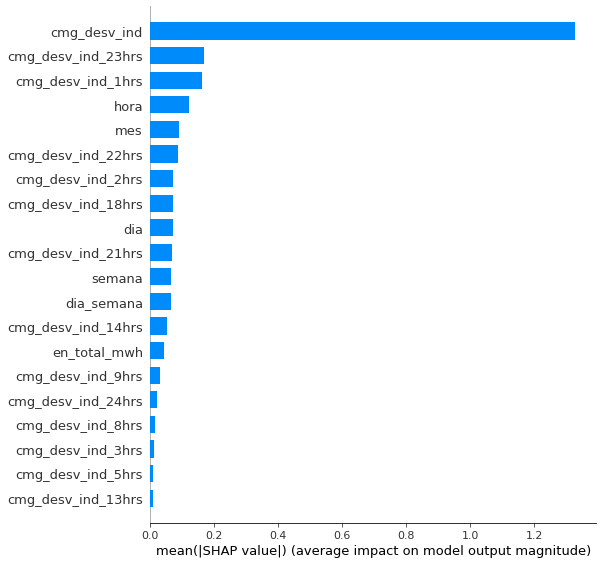

In [697]:
# Graficamos la importancia de las variables usando la libreria SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

Vemos que la variable mas importante del modelo es la misma variable target pero desfasada en una hora. Podemos interpretar esto como que si existe una desviacion en la hora actual , es muy probable que exista una desviacion en la hora siguiente.

### 6. Prediccion de desviaciones del costo marginal: modelo 2<a id='Prediccion-modelo2'>

Si los datos son enviados desde produccion cada 12 horas, debiesemos adaptar el modelo para predecir si existira una desviacion en 12 horas mas. La idea es que con los datos enviados desde produccion podamos generar predicciones de desvio continuamente hasta que nos lleguen los nuevos datos de produccion. En el peor caso tendriamos que generar una prediccion valida con datos de 11 horas atras. Esto obliga a generar una prediccion para 12 horas en el futuro.
<br>
<br>
Algunas ideas a explorar para abordar esta problematica (no creo que alcance a explorarlas todas):
-  Armar solo un modelo de clasificacion para predecir si habra una desviacion para 12 horas en el futuro
-  Armar 12 modelos de clasificacion (1 por cada hora) y usarlos para predecir las 12 horas hacia el futuro
-  Armar solo un modelo de clasificacion que prediga si es que existira una desviacion en algun punto en las proximas 12 horas.
-  Armar dos modelos de regresion lineal para intentar extrapolar tanto la variable costo real como la variable costo programado y usar estos modelos ya sea como features o como una manera de predecir la desviacion

In [698]:
# Idea  1 : armar un solo modelo de clasificacion para 12 horas al futuro
base_modelo2 = base_modelo.copy()

In [699]:
# Desviamos la variable target en 12 horas
desvio_en_hrs = 12
base_modelo2['target'] = base_modelo2.groupby(by=['nemotecnico_se'])['cmg_desv_ind'].shift(-desvio_en_hrs)
base_modelo2.dropna(subset=['target'], inplace=True)

In [700]:
# Añadimos variables correspondientes a la variable "target" desfasada en el tiempo. Notar que este lag debe hacerse agrupando por barra, de otro modo se mezclaran datos entre barras lo que podria ocasionar errores
periodos_lag = 23

for i in range(1, periodos_lag + 1):
    base_modelo2[f"cmg_desv_ind_{i}hrs"] = base_modelo2.groupby(by=['nemotecnico_se'])['cmg_desv_ind'].shift(i)
base_modelo2.dropna(subset=[f"cmg_desv_ind_{i}hrs" for i in range(1, periodos_lag + 1)], inplace=True)

In [701]:
base_modelo2.head(3)

,nemotecnico_se,fecha,hora,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,cmg_desv,cmg_desv_pct,...,cmg_desv_ind_15hrs,cmg_desv_ind_16hrs,cmg_desv_ind_17hrs,cmg_desv_ind_18hrs,cmg_desv_ind_19hrs,cmg_desv_ind_20hrs,cmg_desv_ind_21hrs,cmg_desv_ind_22hrs,cmg_desv_ind_23hrs,cmg_desv_ind_24hrs
165,SE001T002,2019-01-02 00:00:00 UTC,24,NaN,0.0,0.0,48.53,60.317206,-11.79,-19.55,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
166,SE001T002,2019-01-03 00:00:00 UTC,1,NaN,0.0,0.0,49.81,79.147657,-29.34,-37.07,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
167,SE001T002,2019-01-03 00:00:00 UTC,2,NaN,0.0,0.0,49.81,80.763104,-30.95,-38.32,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0


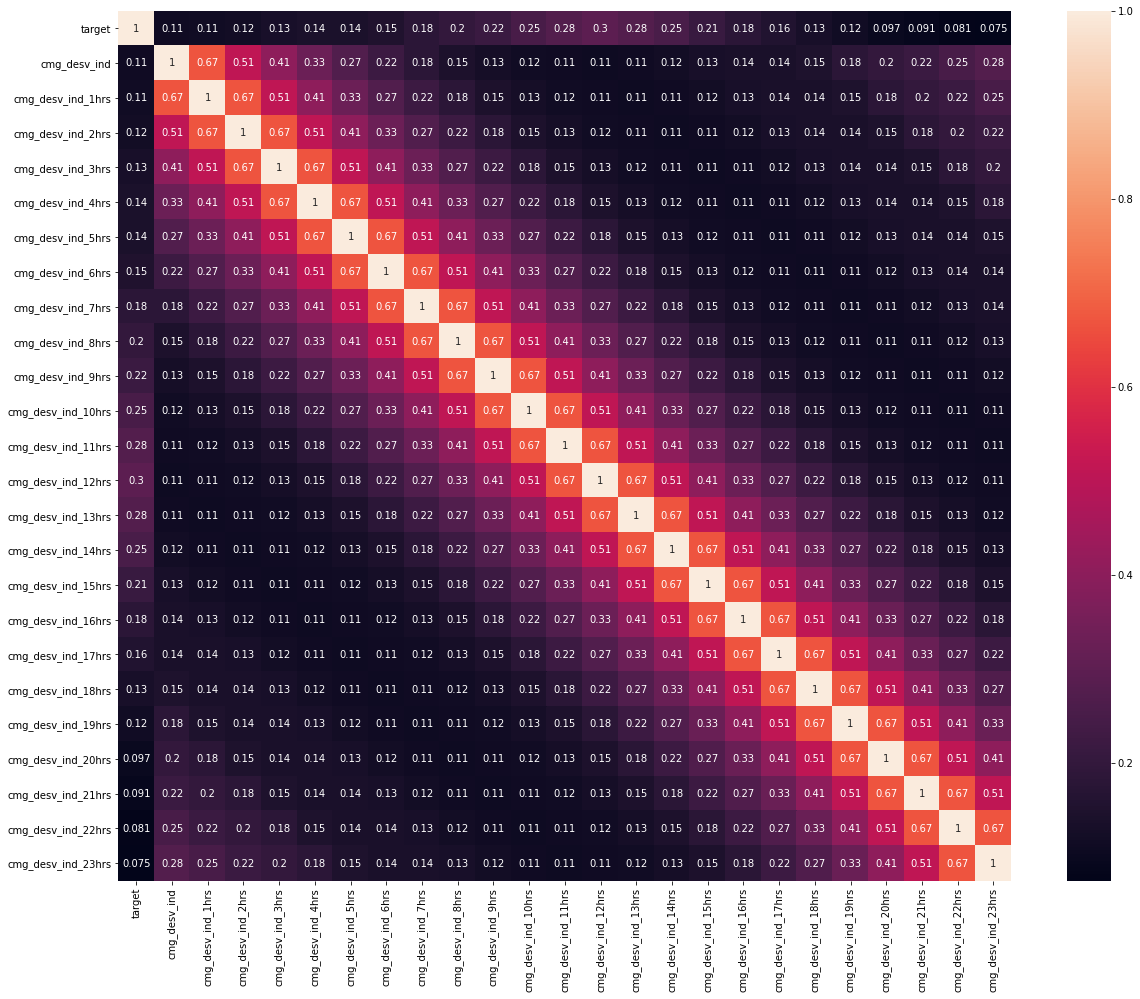

In [702]:
variables_lag = ["cmg_desv_ind"] + [f"cmg_desv_ind_{i}hrs" for i in range(1, periodos_lag + 1)] 
fig, ax = plt.subplots(1,1, figsize=(20,16))
sns.heatmap(base_modelo2[['target'] + variables_lag].corr(), annot=True);

Vemos que al parecer existe una correlacion de la variable target con ella misma (autocorrelacion) desfasada 12, 13 y 14 horas. Podemos interpretar esto como una periodicidad diaria del proceso, donde si mi "costo programado" estuvo desviado del "costo real" el dia anterior, es mas probable que se desvie tambien el dia siguiente a la misma hora.

In [703]:
# Construimos el modelo usando XGBoost
model_12hrs = xgb.XGBClassifier(n_estimators=500, learning_rate=0.01, scale_pos_weight=3, seed=seed)

In [704]:
# Transformamos la base modelo en train/test manteniendo la estructura de la serie de tiempo
X = base_modelo2.drop(columns='target')
X = X[variables_continuas + variables_categoricas + variables_lag]
y = base_modelo2['target']

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.2)

In [705]:
# Entrenamos el modelo usando XGBoost
result_12hrs = model_12hrs.fit(X_train, y_train)

In [706]:
y_pred = result_12hrs.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.86      0.67      0.75     16098
         1.0       0.45      0.70      0.55      6117

    accuracy                           0.68     22215
   macro avg       0.65      0.69      0.65     22215
weighted avg       0.74      0.68      0.69     22215



In [707]:
# Estimamos el indice AUC (Area under the curve), como metrica para evaluar el modelo
fpr, tpr, _ = roc_curve(y_test, y_pred)
print(f'AUC score: {auc(fpr, tpr)}')

AUC score: 0.6854519714370861


Revisando los resultados de nuestro modelo 2 v/s el modelo 1, vemos que efectivamente el performance se ve afectando considerablemente (F1-score:  0.65;  AUC: 0.68). Esto tiene mucho sentido dada la importancia de la variable desfasada en una hora para la prediccion. 

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


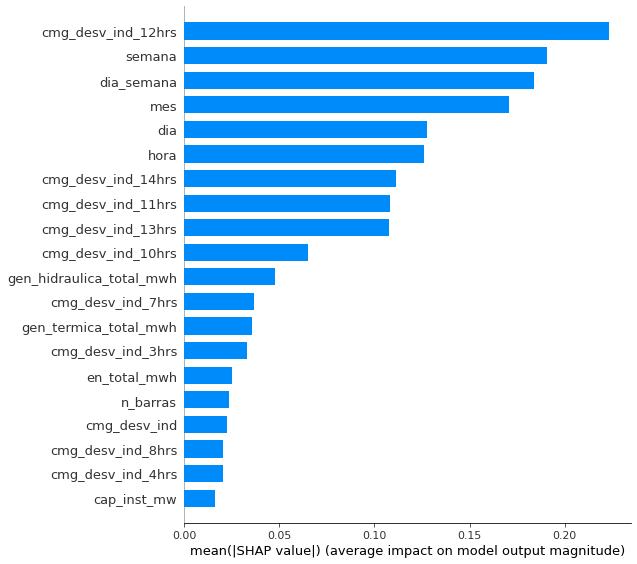

In [708]:
# Graficamos la importancia de las variables usando la libreria SHAP
explainer = shap.TreeExplainer(model_12hrs)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

Tambien vemos que la variable mas importante para la prediccion es la misma variable target pero desfasada en 12 horas lo que reafirma la posibilidad de una periodicidad diaria. Las siguientes variables tambien apuntan a posible estacionalidad por semana, mes, dia y hora.  

### 7. Merge con resultados de clima: modelo 3<a Id=Prediccion-modelo3>

In [709]:
# Leemos los datos de clima
clima = pd.read_csv(datos_clima)
clima.head()

,fecha,subestacion,lat,lon,ALLSKY_SFC_SW_DWN,KT,PRECTOT,RH2M,T2M,T2MDEW,T2M_MAX,T2M_MIN,TQV,TS,WS10M,WS10M_MAX,WS10M_MIN,WS50M,WS50M_MAX,WS50M_MIN
0,2019-05-06 00:00:00 UTC,SE019T002,-28.470641,-71.252694,2.0,0.31,0.00,74.66,16.39,11.94,19.01,13.93,1.78,16.62,4.14,4.93,2.81,5.01,6.23,3.50
1,2019-05-21 00:00:00 UTC,SE005T003,-42.626987,-73.805673,2.0,0.54,0.01,92.82,5.55,4.45,9.39,3.32,0.77,6.50,2.64,2.94,2.04,4.20,4.94,3.55
2,2019-02-28 00:00:00 UTC,SE005T003,-42.626987,-73.805673,2.0,0.21,2.35,88.87,12.25,10.45,15.64,9.61,2.34,12.44,2.62,3.77,1.78,4.16,5.68,2.85
3,2019-01-08 00:00:00 UTC,SE004T002,-39.549899,-72.912208,2.0,0.16,5.96,92.22,9.52,8.30,10.88,7.90,1.62,10.17,2.70,4.02,1.67,4.96,6.87,2.97
4,2019-05-07 00:00:00 UTC,SE003T011,-35.685919,-71.377335,2.0,0.37,0.00,44.02,13.57,1.49,20.38,9.57,1.05,11.34,1.69,3.58,0.65,2.25,4.42,0.96


Revisando los datos del clima, nos damos cuenta que se encuentra abierto por subestacion y fecha. Debido a que no podemos saber con antelacion cual sera la temperatura a cierta hora en cada subestacion, no podemos usar estos datos directamente o estariamos generando "data leakage". Para manejar esto, podemos desfasar los datos en un dia de modo de usar la temperatura de ayer para predecir el target de 12 horas mas.

In [710]:
# Estimamos la fecha desfasada en un dia
clima.sort_values(by=['subestacion','fecha'], inplace=True)
clima['fecha'] = clima.groupby(by=['subestacion'])['fecha'].shift(-1)

In [711]:
# Unimos los datos de clima con los datos de la tabla "base_modelo2"
base_modelo3 = pd.merge(base_modelo2, clima, left_on=['nemotecnico_se', 'fecha'], right_on=['subestacion', 'fecha'], right_index=False)

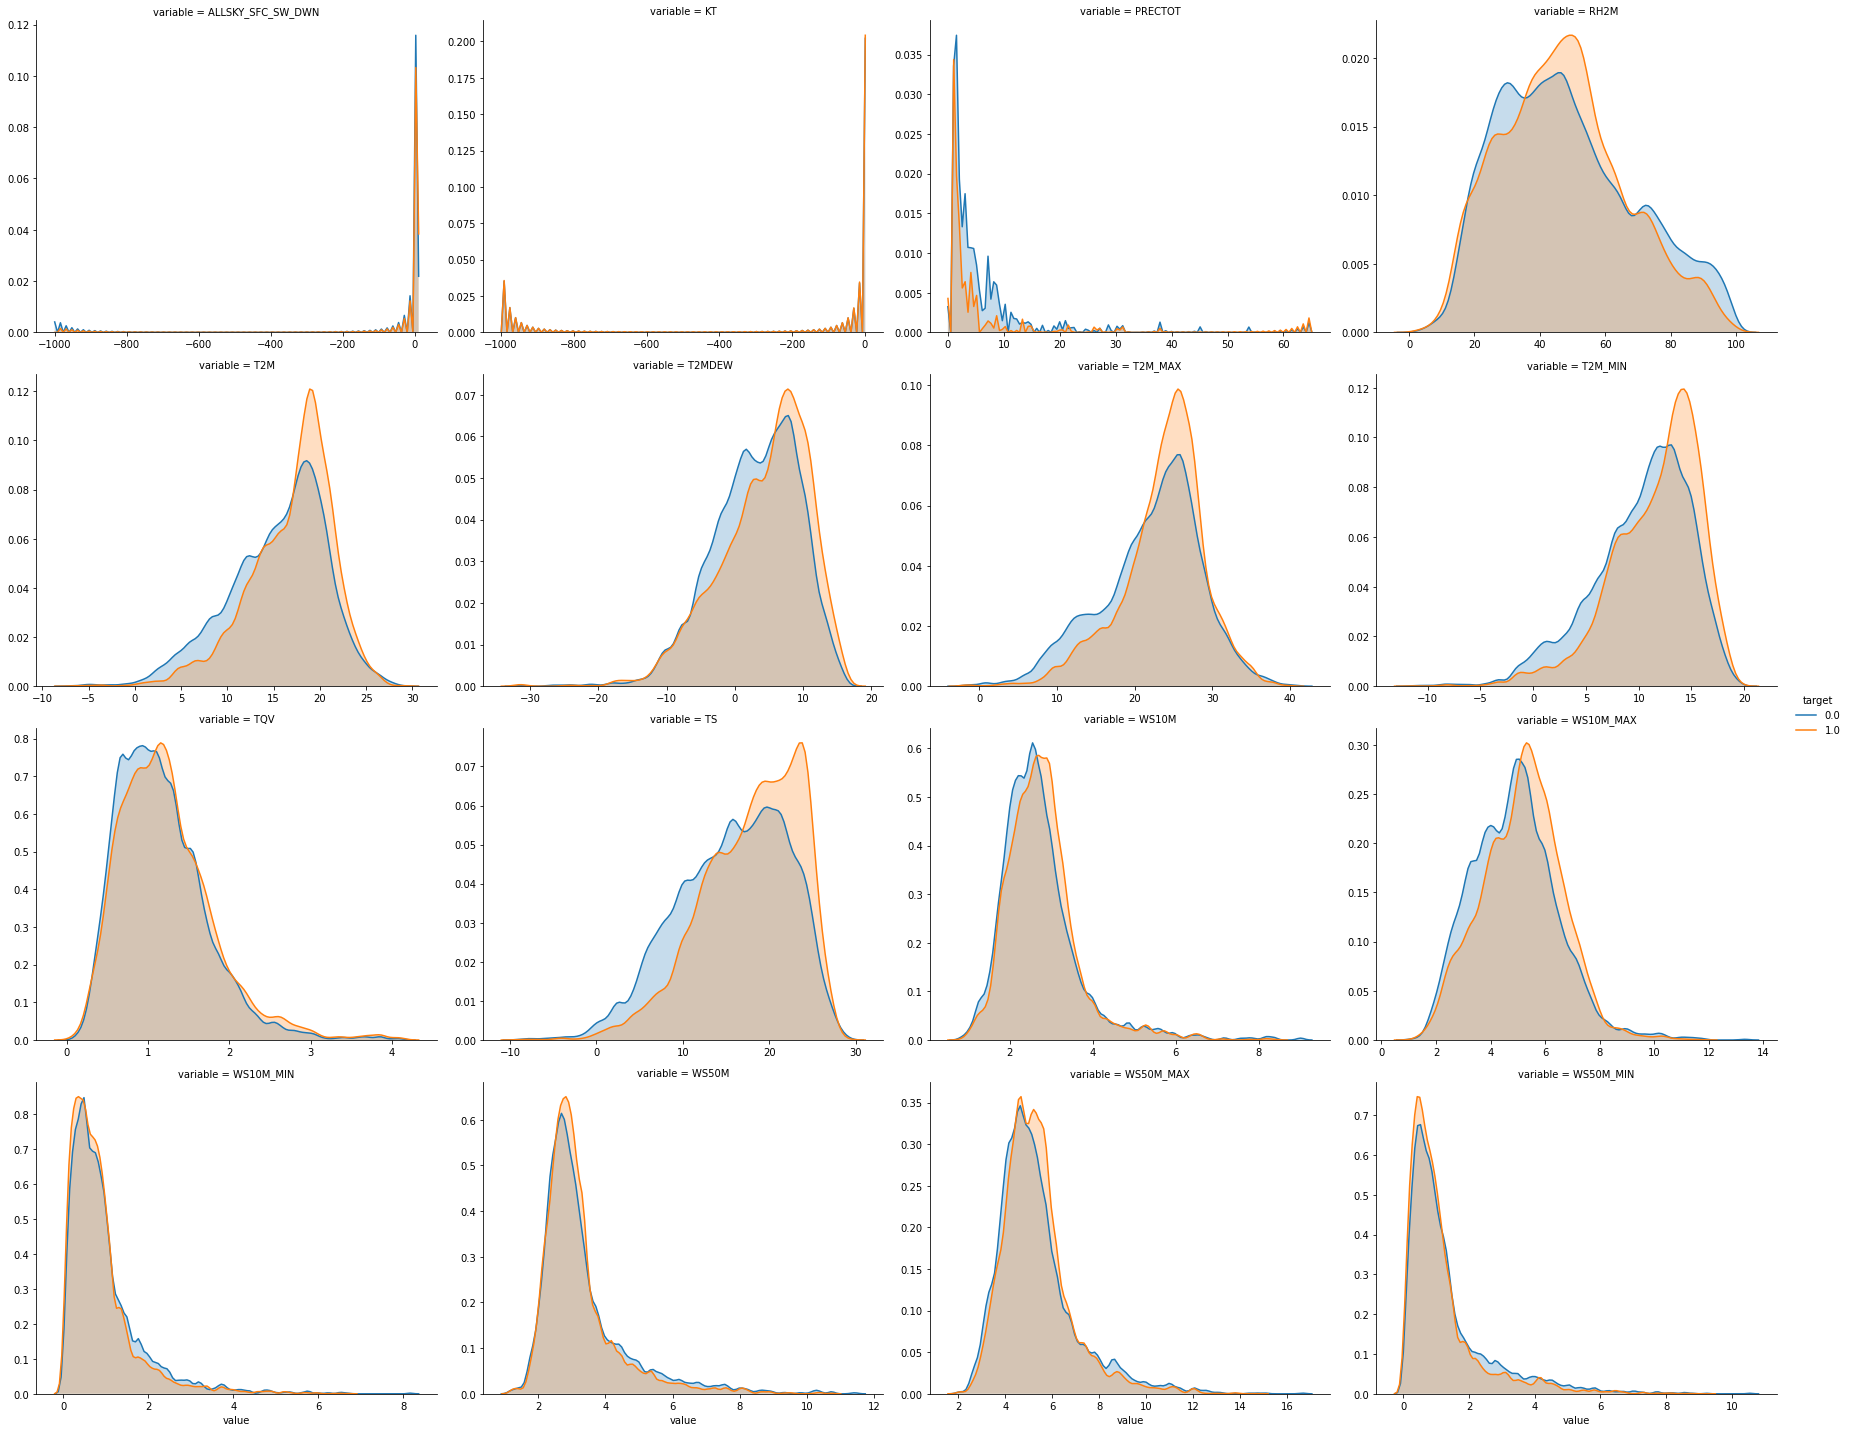

In [712]:
# Revisamos la distribucion de las variables de clima versus la variable target
variables_clima = ['ALLSKY_SFC_SW_DWN', 'KT', 'PRECTOT', 'RH2M', 'T2M', 'T2MDEW', 'T2M_MAX', 'T2M_MIN', 'TQV', 'TS', 'WS10M', 'WS10M_MAX', 'WS10M_MIN', 'WS50M', 'WS50M_MAX', 'WS50M_MIN']

base_modelo_transformada = pd.melt(base_modelo3, 'target', variables_clima).fillna(0)
g = sns.FacetGrid(base_modelo_transformada, col="variable", hue="target", col_wrap=4, sharex=False, sharey=False,height=5,aspect=1.25)
g.map(sns.kdeplot, "value", shade=True)
g.add_legend();

Vemos que no existe una gran diferencia de distribucion entre los datos con o sin desvio entre el "costo real" y el "costo programado". A raiz de lo anterior, no esperamos que haya una gran diferencia en el performance del modelo considerando o no estos datos.

In [713]:
# Entrenamos un nuevo modelo considerando los datos del clima
model_clima = xgb.XGBClassifier(n_estimators=500, learning_rate=0.01, scale_pos_weight=3, seed=seed)

In [714]:
# Transformamos la base modelo en train/test manteniendo la estructura de la serie de tiempo
X = base_modelo3.drop(columns='target')
X = X[variables_continuas + variables_categoricas + variables_lag + variables_clima]
y = base_modelo3['target']

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.2)

In [715]:
# Entrenamos el modelo usando XGBoost
result_clima = model_clima.fit(X_train, y_train)

In [716]:
y_pred = result_clima.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.66      0.74     16098
         1.0       0.44      0.69      0.53      6117

    accuracy                           0.67     22215
   macro avg       0.64      0.67      0.64     22215
weighted avg       0.73      0.67      0.69     22215



In [717]:
# Estimamos el indice AUC (Area under the curve), como metrica para evaluar el modelo
fpr, tpr, _ = roc_curve(y_test, y_pred)
print(f'AUC score: {auc(fpr, tpr)}')

AUC score: 0.6745202920001211


Revisando los resultadoss (F1-score: 0.64  ; AUC: 0.675) , vemos que el modelo se comporta mas menos igual que el modelo 2. Esto era esperable considerando como las variables de clima se distribuian respecto a la variable target.

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


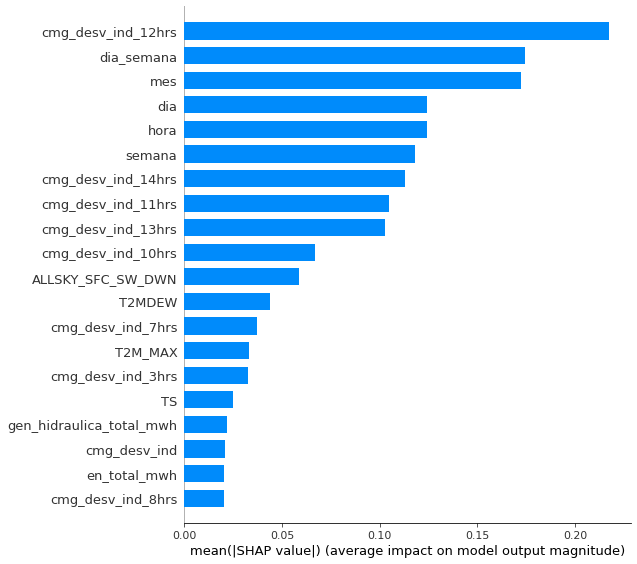

In [718]:
# Graficamos la importancia de las variables usando la libreria SHAP
explainer = shap.TreeExplainer(model_clima)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

Al revisar la relevancia de las variables para el modelo predictivo, vemos que las variables de clima no aparecen en el top 5, por lo que podemos concluir que el clima no es un gran factor que afecte en el desvio entre el costo real y el costo programado

### 8. Reflexion<a Id=Reflexion>

1. Contar con un modelo que permita anticiparse a desvios de precios de la energia, permite tomar acciones para mitigar los impactos de este incremento. Algunos ejemplos podrian ser los siguientes:
    - Ajustar el precio para consumidores finales, traspasando el incremento del costo al precio final de la energia
    - Transparentar esta informacion con potenciales actores en el mercado de generacion electrica. La idea seria motivar una mayor generacion de electricidad en esos "peak" y de esta forma generar una reduccion en los costos marginales para estos periodos

2. Como potenciales casos de uso para este modelo, imagino los siguientes:
    - Una web app que permita predecir el costo final real de electricidad de una casa utilizando su boleta digital. El modelo actual podria ayudar a ajustar el precio final considerando los desvios en los costos
    - Distribuir esta informacion con potenciales actores de generacion electrica para motivar el incremento de generacion de electricidad para estos periodos